### Imports

In [1]:
from tqdm import tqdm
import random
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_mtsim
sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/")
from gym_mtsim_forked.gym_mtsim.data import FOREX_DATA_PATH, FOREX_DATA_PATH_1HR, FOREX_DATA_PATH_15MIN, FOREX_DATA_PATH_5MIN
from gym_mtsim import OrderType, Timeframe, MtEnv, MtSimulator
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, STATUS_FAIL
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
import time
import torch
import pickle
import fx_rl
from datetime import datetime, timedelta
import pytz

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment forex-hedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment forex-unhedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment stocks-hedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment stocks-unhedge-v0 alr

## Latest Data

In [2]:
now = datetime.now()
current_time = pd.to_datetime(now) + timedelta(hours=7)
current_time = current_time.replace(tzinfo=pytz.UTC)
# date_15min = fx_rl.bars_back(current_time, 'M15')
# date_5min = fx_rl.bars_back(current_time, 'M5')
date_1hr = fx_rl.bars_back(current_time, 'H1', total_bars=50_000)


In [3]:
sim = MtSimulator(
    unit='USD',
    balance=10000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=False,
)
sim.download_data(
    symbols=['EURUSD', 'AUDCHF', 'NZDCHF', 'GBPNZD', 'USDCAD'],
    time_range=(
        date_1hr,
        current_time
    ),
    timeframe=Timeframe.H1
)
sim.save_symbols(FOREX_DATA_PATH)
# sim.save_symbols(f'symbols_forex_15min_{date_1hr.date()}_{current_time.date()}.pkl')

In [4]:
# with open(f'symbols_forex_5min_2023-01-09_2024-05-08', 'rb') as f:
#     symbols_5min = pickle.load(f)
# # convert symbols_5min to a pd.dataframe
# symbols_5min[1]['EURUSD'].index = pd.to_datetime(symbols_5min[1]['EURUSD'].index)
# max_date_5min = symbols_5min[1]['EURUSD'].index.max()

In [5]:
# with open(f'symbols_forex_15min_2020-05-11_2024-05-08', 'rb') as f:
#     symbols_15min = pickle.load(f)
# # convert symbols_15min to a pd.dataframe
# symbols_15min[1]['EURUSD'].index = pd.to_datetime(symbols_15min[1]['EURUSD'].index)
# max_date_15min = symbols_15min[1]['EURUSD'].index.max()

In [6]:
with open(FOREX_DATA_PATH, 'rb') as f:
    symbols_1hr = pickle.load(f)
# convert symbols_1hr to a pd.dataframe
symbols_1hr[1]['EURUSD'].index = pd.to_datetime(symbols_1hr[1]['EURUSD'].index)
max_date_1hr = symbols_1hr[1]['EURUSD'].index.max()

In [7]:
# # unpack the pickle file and load the data that is in symbols_forex.pkl
# with open(FOREX_DATA_PATH, 'rb') as f:
#     symbols = pickle.load(f)
# # convert symbols to a pd.dataframe
# # symbols[1]['EURUSD']

In [8]:
# slices_5min = fx_rl.slices_finder(symbols_5min[1]['EURUSD'], max_date_5min, testing_needed=True)
# slices_15min = fx_rl.slices_finder(symbols_15min[1]['EURUSD'], max_date_15min, testing_needed=True)
slices_1hr = fx_rl.slices_finder(symbols_1hr[1]['EURUSD'], max_date_1hr, testing_needed=False)

### Create Env

In [9]:
# class MyMtEnv(gym_mtsim.MtEnv):
#     # _get_modified_volume = fx_rl.my_get_modified_volume
#     _get_prices = fx_rl.my_get_prices

In [10]:
sim_train_1hr = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_train_1hr = gym_mtsim.MtEnv(
    original_simulator=sim_train_1hr,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=slices_1hr[0],
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [11]:
# sim_train_15min = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH_15MIN
# )

# env_train_15min = gym_mtsim.MtEnv(
#     original_simulator=sim_train_15min,
#     trading_symbols=['EURUSD'],
#     window_size = 10,
#     time_points=slices_15min[0],
#     hold_threshold=0.5,
#     close_threshold=0.5,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

In [12]:
# sim_train_5min = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH_5MIN
# )

# env_train_5min = gym_mtsim.MtEnv(
#     original_simulator=sim_train_5min,
#     trading_symbols=['EURUSD'],
#     window_size = 10,
#     time_points=slices_5min[0],
#     hold_threshold=0.5,
#     close_threshold=0.5,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

In [13]:
sim_validation_1hr = MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_validation_1hr = gym_mtsim.MtEnv(
    original_simulator=sim_validation_1hr,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=slices_1hr[1],
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [14]:
# sim_validation_15min = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH_15MIN
# )

# env_validation_15min = gym_mtsim.MtEnv(
#     original_simulator=sim_validation_15min,
#     trading_symbols=['EURUSD'],
#     window_size = 10,
#     time_points=slices_15min[1],
#     hold_threshold=0.5,
#     close_threshold=0.5,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

In [15]:
# sim_validation_5min = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH_5MIN
# )

# env_validation_5min = gym_mtsim.MtEnv(
#     original_simulator=sim_validation_5min,
#     trading_symbols=['EURUSD'],
#     window_size = 10,
#     time_points=slices_5min[1],
#     hold_threshold=0.5,
#     close_threshold=0.5,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

In [16]:
# sim_testing = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH
# )

# env_testing = MyMtEnv(
#     original_simulator=sim_testing,
#     trading_symbols=['EURUSD'],
#     window_size = 10,
#     time_points=slices_1hr[2],
#     hold_threshold=0.5,
#     close_threshold=0.5,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

### Define Functions

In [17]:
def print_stats(reward_over_episodes, printing_name):
    """  Print Reward  """

    avg_rewards = np.mean(reward_over_episodes)
    min_rewards = np.min(reward_over_episodes)
    max_rewards = np.max(reward_over_episodes)

    print (f'Min. {printing_name}          : {min_rewards:>10.3f}')
    print (f'Avg. {printing_name}          : {avg_rewards:>10.3f}')
    print (f'Max. {printing_name}          : {max_rewards:>10.3f}')

    return min_rewards, avg_rewards, max_rewards

def my_profit_calculation(env_orders, stop_loss):
        # env_orders = env_testing.render()['orders']
        # stop_loss = 0.001
        mean_value = env_orders['Volume'].mean()

        # # Normalize the column to have a mean of 1
        env_orders.loc[:, 'Volume'] = round((env_orders['Volume'] / mean_value), 2)

        # add a column for when the difference between the Entry Price and the Exit Price is greater than stop_loss
        env_orders.loc[:, 'stoploss_hit'] = np.where((env_orders['Type'].str.strip() == 'Buy') &
                                                        ((env_orders['Entry Price'] - env_orders['Exit Price']) > stop_loss),
                                                        1, np.where((env_orders['Type'].str.strip() == 'Sell') &
                                                                        ((env_orders['Exit Price'] - env_orders['Entry Price']) > stop_loss),
                                                                        1, 0))
        env_orders.loc[:, 'Exit Price'] = np.where((env_orders['Type'].str.strip() == 'Buy') & (env_orders['stoploss_hit'] == 1),
                                                        env_orders['Entry Price'] - stop_loss,
                                                        np.where((env_orders['Type'].str.strip() == 'Sell') & (env_orders['stoploss_hit'] == 1),
                                                                env_orders['Entry Price'] + stop_loss, env_orders['Exit Price']))
        env_orders.loc[:, 'Profit'] = np.where((env_orders['Type'].str.strip() == 'Buy'),
                                                        ((env_orders['Exit Price'] - (env_orders['Fee']/2)) - 
                                                        (env_orders['Entry Price'] + (env_orders['Fee']/2)))
                                                                * 100_000 * env_orders['Volume'], 
                                                        np.where((env_orders['Type'].str.strip() == 'Sell'),
                                                                ((env_orders['Entry Price'] - (env_orders['Fee']/2)) - 
                                                                (env_orders['Exit Price'] + (env_orders['Fee']/2)))
                                                                * 100_000 * env_orders['Volume'], np.nan))
        total_reward = env_orders.loc[:, 'Profit'].sum()
        # Calculate Gross Profit
        gross_profit = env_orders.loc[env_orders['Profit'] > 0, 'Profit'].sum()

        # Calculate Gross Loss
        gross_loss = env_orders.loc[env_orders['Profit'] < 0, 'Profit'].abs().sum()

        # Calculate Profit Factor
        profit_factor = gross_profit / gross_loss if gross_loss != 0 else 0

        profit_factor = profit_factor - 1

        return profit_factor, total_reward

# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


In [18]:
space = {
    # 'learning_rate': hp.loguniform('learning_rate', -5, -2), # Learning rate
    'learning_rate': hp.uniform('learning_rate', 0, 0.04), # Learning rate
    'gamma': hp.uniform('gamma', 0.925, 0.975), # Discount factor
    # 'ent_coef': hp.loguniform('ent_coef', -5, 0) # Entropy coefficient
    'ent_coef': hp.uniform('ent_coef', 0, 0.05), # Entropy coefficient
    # 'learning_timesteps': hp.choice('learning_timesteps', [25, 50, 100, 250, 500]),
    # 'timeframe': hp.choice('timeframe', ['5min', '15min', '1hr'])
}

In [19]:
# TRAINING + TEST
def train_val_model(model, model_policy, env_tr, env_val, seed, steps_str, lr, gamma_param, entropy, total_learning_timesteps=10_000):
    """
    Trains and validates a model using the Proximal Policy Optimization (PPO) algorithm.

    Args:
        model (object): The model to be trained.
        model_policy (object): The policy used by the model.
        env_tr (object): The training environment.
        env_val (object): The validation environment.
        seed (int): The random seed for reproducibility.
        steps_str (str): A string representing the number of steps.
        window_size_param (int): The window size parameter.
        lr (float): The learning rate.
        gamma_param (float): The gamma parameter.
        entropy (float): The entropy coefficient.
        total_learning_timesteps (int, optional): The total number of learning timesteps. Defaults to 10,000.

    Returns:
        tuple: A tuple containing the reward over validations, orders over validations, and the model dictionary.
    """
    # reproduce training and test
    print('-' * 80)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    #model_dict = {}
    # env_tr.window_size = window_size_param
    print(f'entropy: {entropy}, learning rate: {lr}, gamma: {gamma_param}')
    # eval_callback = EvalCallback(env_tr, log_path='./logs/', eval_freq=1000)
    obs_tr, info_tr = env_tr.reset(seed=seed)
    model = PPO(model_policy, env_tr, verbose=0, ent_coef=entropy, learning_rate=lr)#, gamma=gamma_param, 
    # custom callback for 'progress_bar'
    model.learn(total_timesteps=total_learning_timesteps)#, callback=ProgressBarCallback(100))

    reward_over_validations = []
    orders_over_validations = []
    profit_over_validations = []

    for episode in range(0, 10):
        obs_val, info_val = env_val.reset(seed=seed)

        total_reward = 0
        done_val = False

        while not done_val:
            action, _states = model.predict(obs_val)
            obs_val, reward_val, terminated_val, truncated_val, info_val = env_val.step(action)
            done_val = terminated_val or truncated_val

            total_reward += reward_val
            if done_val:
                break
        try:
            orders_made_in_episode = env_val.render()['orders']
            order_len = len(orders_made_in_episode)
            total_reward, total_profit = my_profit_calculation(orders_made_in_episode, 0.001)
            
        except Exception as e:
            print(f'There were not any orders produced by the model. Error: {e}')
            order_len = 0
            total_profit = 0

        # model_dict[f'model_{episode}'] = model
        # model.save(f'best_hyperparameters/models_4_26_24/model_{episode}.pkl')

        reward_over_validations.append(total_reward) 
        profit_over_validations.append(total_profit)   
        orders_over_validations.append(order_len)  


        # if episode % 1 == 0:
        # avg_reward = np.mean(reward_over_validations)
        # avg_orders = np.mean(orders_over_validations)
        # avg_profit = np.mean(profit_over_validations)
        # print(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f}, # of orders: {avg_orders:.3f}, avg Profit: {avg_profit:.3f}')
    if np.mean(profit_over_validations) > 0:
        model.save(f'models_{max_date_1hr.date()}/model_{steps_str}_{max_date_1hr.date()}.pkl')
    return reward_over_validations, orders_over_validations, profit_over_validations#, model_dict

In [20]:
import os
# create a folder with the name of the date
os.makedirs(f'models_{max_date_1hr.date()}', exist_ok=True)

## Objective Function

In [21]:
seed = 2024  # random seed
total_num_episodes = 10

# print ("env_name                 :", env_name)
print ("seed                     :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# learning_timesteps_list_in_K = [25]#, 50, 100]
# learning_timesteps_list_in_K = [50, 250, 500]
# learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html
step_key = 0
timesteps_models_dict = {}
def objective(params):
    learning_timesteps = 250 #params['learning_timesteps']
    ent_coef = params['ent_coef']
    gamma = params['gamma'] #0.99 #
    learning_rate = params['learning_rate']#0.0003#
    global step_key

    # timeframe = params['timeframe']
    # if timeframe == '5min':
    #     env_train = env_train_5min
    #     env_validation = env_validation_5min
    # elif timeframe == '15min':
    #     env_train = env_train_15min
    #     env_validation = env_validation_15min
    # elif timeframe == '1hr':
    #     env_train = env_train_1hr
    #     env_validation = env_validation_1hr

    if learning_rate > 0.08:
        print(f'Learning rate too high: {learning_rate}')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    if ent_coef > 0.1:
        print(f'Entropy too high: {ent_coef}')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}

    total_learning_timesteps = learning_timesteps * 1000
    step_key += 1
    policy_dict = PPO.policy_aliases
    policy = policy_dict.get('MultiInputPolicy')
    class_name = type(PPO).__qualname__
    # plot_key = f'{class_name}_rewards_'+step_key
    try:
        rewards, orders, profits = train_val_model(PPO, policy, env_train_1hr, env_validation_1hr, seed, step_key,  
                                                    learning_rate, gamma, ent_coef, total_learning_timesteps)
    except Exception as e:
        if 'Tensor of shape' in str(e):
            print(f'''there was an error with the tensor with those parameters: timesteps: {learning_timesteps}, \n
              ent_coef: {ent_coef}, gamma: {gamma}, learning_rate: {learning_rate}''')
        else:
            print(f'''there was an error {e} with those parameters: timesteps: {learning_timesteps}, \n
                ent_coef: {ent_coef}, gamma: {gamma}, learning_rate: {learning_rate}''')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    # timesteps_models_dict[step_key] = models_dict
    min_rewards, avg_rewards, max_rewards, = print_stats(profits, 'Profits')
    print_stats(orders, 'Orders')
    # label = f'Avg. {avg_rewards:>7.2f} : {class_name} - {step_key}'
    # plot_data[plot_key] = rewards
    # plot_settings[plot_key] = {'label': label}
    params['avg_orders'] = np.mean(orders)
    params['rewards'] = np.mean(rewards)       

    return {'loss': -avg_rewards, 'status': STATUS_OK, 'eval_time': time.time(), 'parameters': params} 

seed                     : 2024


In [22]:
# # # check if it is working:
# parameters = {
#     # 'window_size': 10,
#     # 'learning_timesteps': 25,
#     'ent_coef': 0.008841807731982131,
#     # 'gamma': 0.9484679718228304,
#     'learning_rate': 0.021173768344759137
# }
# objective(parameters)

In [23]:

# PPO('MultiInputPolicy', env_train, verbose=0, ent_coef=parameters['ent_coef']).learn(total_timesteps=25_000) #, learning_rate=parameters['learning_rate'], gamma=parameters['gamma'], ent_coef=parameters['ent_coef']

In [24]:
#### adding in gamma test ####
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=250, # Number of evaluations of the objective function
            trials=trials,
            trials_save_file=f'gym_mtsim_forked/examples/hyperopt/trials_{max_date_1hr.date()}_search_next_week.pkl')

print("Best parameters:", best)

--------------------------------------------------------------------------------
entropy: 0.024093233151116552, learning rate: 0.028232775623937438, gamma: 0.9367494409265381
Min. Profits          :   -869.958                     
Avg. Profits          :     12.773                     
Max. Profits          :   1432.201                     
Min. Orders          :     15.000                      
Avg. Orders          :     32.300                      
Max. Orders          :     52.000                      
--------------------------------------------------------------------------------      
entropy: 0.014659817999726765, learning rate: 0.037461366721183734, gamma: 0.9661411673444934
Min. Profits          :   -776.648                                                    
Avg. Profits          :     27.053                                                    
Max. Profits          :   1693.779                                                    
Min. Orders          :     15.000              

In [25]:
# # make a sound when the code is done
# import winsound
# frequency = 2500  # Set Frequency To 2500 Hertz
# duration = 2000  # Set Duration To 1000 ms == 1 second
# winsound.Beep(frequency, duration)

# Testing Hyperparameters

In [26]:
trials_latest_week = pickle.load(open(f'gym_mtsim_forked/examples/hyperopt/trials_{max_date_1hr.date()}_search_next_week.pkl', 'rb'))
trials_latest_week_all_results = trials_latest_week.results
print(len(trials_latest_week_all_results),
trials_latest_week_all_results[0])

250 {'loss': -12.772530298457568, 'status': 'ok', 'eval_time': 1718397152.4215474, 'parameters': {'ent_coef': 0.024093233151116552, 'gamma': 0.9367494409265381, 'learning_rate': 0.028232775623937438, 'avg_orders': 32.3, 'rewards': -0.07610798098066554}}


In [27]:
best_hyperparameters_current_week = pd.DataFrame()
new_dict = {}
for idx, result in enumerate(trials_latest_week_all_results):
    new_dict['loss'] = result['loss']
    new_dict['status'] = result['status']
    new_dict['learning_rate'] = result['parameters']['learning_rate']
    new_dict['ent_coef'] = result['parameters']['ent_coef']
    new_dict['gamma'] = result['parameters']['gamma']
    try:
        new_dict['orders'] = result['parameters']['avg_orders']
        new_dict['rewards'] = result['parameters']['rewards']
    except Exception as e: 
        new_dict['orders'] = 0
        new_dict['rewards'] = 0
    new_row = pd.DataFrame(new_dict, index=[idx])
    best_hyperparameters_current_week = pd.concat([best_hyperparameters_current_week, new_row], axis=0)
best_hyperparameters_current_week

,loss,status,learning_rate,ent_coef,gamma,orders,rewards
0,-12.772530,ok,0.028233,0.024093,0.936749,32.3,-0.076108
1,-27.053161,ok,0.037461,0.014660,0.966141,31.9,-0.067081
2,79.129484,ok,0.020719,0.030096,0.942720,29.5,-0.171935
3,-42.304789,ok,0.014926,0.047559,0.954263,31.9,-0.042750
4,-509.470370,ok,0.029544,0.007035,0.953352,19.7,0.671506
...,...,...,...,...,...,...,...
245,74.010098,ok,0.016040,0.002025,0.941213,13.0,-0.059847
246,186.022952,ok,0.008289,0.023923,0.935683,27.4,-0.273638
247,-1608.444687,ok,0.000733,0.005840,0.962046,37.2,1.112654
248,-92.638285,ok,0.000580,0.002799,0.963096,0.6,0.489495


In [28]:
best_hyperparameters_current_week_success = best_hyperparameters_current_week[best_hyperparameters_current_week['status'] == 'ok']
best_hyperparameters_current_week_success_negative = best_hyperparameters_current_week_success[best_hyperparameters_current_week_success['loss'] < 0]
best_hyperparameters_current_week_success_negative = best_hyperparameters_current_week_success_negative.sort_values(by='loss', ascending=True)
best_hyperparameters_current_week_success_negative

,loss,status,learning_rate,ent_coef,gamma,orders,rewards
226,-1629.155389,ok,0.004407,0.006963,0.940741,52.9,0.882235
247,-1608.444687,ok,0.000733,0.005840,0.962046,37.2,1.112654
186,-1410.419687,ok,0.006056,0.004385,0.929802,22.2,1.566427
153,-1321.874891,ok,0.000660,0.002435,0.951458,8.4,12.154049
36,-1299.164820,ok,0.009414,0.015512,0.944871,37.6,1.138518
...,...,...,...,...,...,...,...
185,-4.073700,ok,0.014193,0.009929,0.947019,46.8,0.036451
164,-3.929013,ok,0.005389,0.001062,0.938205,101.1,0.023890
210,-1.212068,ok,0.014167,0.005315,0.936034,0.3,-0.300000
173,-1.074586,ok,0.005920,0.009756,0.925187,0.3,-0.300000


In [29]:
total_learning_timesteps = 250 * 1_000

In [30]:
custom_palette = sns.color_palette(["red", "green"])

In [31]:
def env_fx(slices):
    sim_training = gym_mtsim.MtSimulator(
        unit='USD',
        balance=200000.,
        leverage=100.,
        stop_out_level=0.2,
        hedge=True,
        symbols_filename=FOREX_DATA_PATH
    )
    env_training = gym_mtsim.MtEnv(
        original_simulator=sim_training,
        trading_symbols=['EURUSD'],
        window_size = 10,
        time_points= slices[0],
        hold_threshold=0.5,
        close_threshold=0.5,
        fee=lambda symbol: {
            # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
            'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
            # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
        }[symbol],
        symbol_max_orders=2,
        multiprocessing_processes=2
    )
    sim_validation = gym_mtsim.MtSimulator(
        unit='USD',
        balance=200000.,
        leverage=100.,
        stop_out_level=0.2,
        hedge=True,
        symbols_filename=FOREX_DATA_PATH
    )
    env_validation = gym_mtsim.MtEnv(
        original_simulator=sim_validation,
        trading_symbols=['EURUSD'],
        window_size = 10,
        time_points= slices[1],
        hold_threshold=0.5,
        close_threshold=0.5,
        fee=lambda symbol: {
            # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
            'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
            # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
        }[symbol],
        symbol_max_orders=2,
        multiprocessing_processes=2
    )
    return env_training, env_validation

In [32]:
# find all of the models that are in the /models_2024_05_17 folder
folder_path = f'C:/Users/WilliamFetzner/Documents/Trading/models_{max_date_1hr.date()}'

# Get the list of files in the folder
file_list = os.listdir(folder_path)
file_list[0]

'model_103_2024-06-14.pkl'

In [33]:
file_list

['model_103_2024-06-14.pkl',
 'model_105_2024-06-14.pkl',
 'model_106_2024-06-14.pkl',
 'model_107_2024-06-14.pkl',
 'model_108_2024-06-14.pkl',
 'model_109_2024-06-14.pkl',
 'model_113_2024-06-14.pkl',
 'model_118_2024-06-14.pkl',
 'model_120_2024-06-14.pkl',
 'model_121_2024-06-14.pkl',
 'model_125_2024-06-14.pkl',
 'model_126_2024-06-14.pkl',
 'model_127_2024-06-14.pkl',
 'model_132_2024-06-14.pkl',
 'model_134_2024-06-14.pkl',
 'model_135_2024-06-14.pkl',
 'model_137_2024-06-14.pkl',
 'model_13_2024-06-14.pkl',
 'model_140_2024-06-14.pkl',
 'model_141_2024-06-14.pkl',
 'model_142_2024-06-14.pkl',
 'model_143_2024-06-14.pkl',
 'model_145_2024-06-14.pkl',
 'model_146_2024-06-14.pkl',
 'model_147_2024-06-14.pkl',
 'model_150_2024-06-14.pkl',
 'model_151_2024-06-14.pkl',
 'model_152_2024-06-14.pkl',
 'model_153_2024-06-14.pkl',
 'model_154_2024-06-14.pkl',
 'model_156_2024-06-14.pkl',
 'model_159_2024-06-14.pkl',
 'model_160_2024-06-14.pkl',
 'model_161_2024-06-14.pkl',
 'model_162_202

In [34]:
# get the model number from the file name when the file name has the format 'model_##_2024-05-17.pkl' where the ## is the model number
model_nums = [x.split('_')[1] for x in file_list]

In [35]:
# test which version of the model to take, does it make a difference whether I use model_0 or model_9
seed=2024
num_episodes = 1_000

total_reward = 0
done_test = False
reward_over_tests = {}
time_now = datetime.now()

train_env, env_validation_2 = env_fx(slices_1hr)
obs_test, info_test = env_validation_2.reset(seed=seed)
obs_tr, info_tr = train_env.reset(seed=seed)

for num, model in tqdm(zip(model_nums, file_list)):

    # model_ppo = PPO('MultiInputPolicy', train_env, verbose=0, ent_coef=m_ppo_ent_coef, learning_rate=m_ppo_lr, gamma=m_ppo_gamma)
    obs_tr, info_tr = train_env.reset(seed=seed)
    model_ppo = PPO.load(f'models_{max_date_1hr.date()}/{model}', train_env)
    # model_ppo.learn(total_timesteps=total_learning_timesteps, callback=ProgressBarCallback(100))   

    rewards = []
    for episode in range(num_episodes):
        obs_test, info_test = env_validation_2.reset(seed=seed)
        # model_ppo = PPO.load(f'gym_mtsim_forked/gym_mtsim/data/model_0.pkl', train_env)
        done_test = False
        while not done_test:
            action, _states = model_ppo.predict(obs_test)
            obs_test, reward_test, terminated_test, truncated_test, info_test = env_validation_2.step(action)
            done_test = terminated_test or truncated_test
            
            total_reward += reward_test
            if done_test:
                break
        try:
            orders_made_in_episode_test = env_validation_2.render()['orders']
            # orders_over_validations_dfs[f'{episode}'] = orders_made_in_episode_test
            order_len = len(orders_made_in_episode_test)
            total_reward, total_profit = my_profit_calculation(orders_made_in_episode_test, 0.001)
            rewards.append(total_profit)
        except Exception as e:
            print(f'There were not any orders produced by the model. Error = {e}')
            rewards.append(0)
            order_len = 0
    print_stats(rewards, 'Profits')
    reward_over_tests[f'model_{num}'] = rewards
# print(f'Finished day_{mins} in {int((datetime.now() - time_now).seconds/60)} minutes')


1it [02:00, 120.65s/it]

Min. Profits          :   -888.003
Avg. Profits          :    258.904
Max. Profits          :   3289.751


2it [04:00, 120.08s/it]

Min. Profits          :   -793.550
Avg. Profits          :    270.973
Max. Profits          :   2819.577


3it [06:01, 120.42s/it]

Min. Profits          :   -869.384
Avg. Profits          :    303.935
Max. Profits          :   3501.517


4it [08:02, 120.90s/it]

Min. Profits          :   -896.141
Avg. Profits          :    295.613
Max. Profits          :   2677.917


5it [10:02, 120.55s/it]

Min. Profits          :   -919.955
Avg. Profits          :    268.408
Max. Profits          :   3698.500


6it [12:01, 119.82s/it]

Min. Profits          :  -1456.973
Avg. Profits          :    341.855
Max. Profits          :   2804.383


7it [14:03, 120.56s/it]

Min. Profits          :  -1015.272
Avg. Profits          :    278.824
Max. Profits          :   2843.206


8it [16:02, 120.11s/it]

Min. Profits          :   -920.628
Avg. Profits          :    256.492
Max. Profits          :   2831.129


9it [18:02, 120.13s/it]

Min. Profits          :   -968.793
Avg. Profits          :    291.868
Max. Profits          :   3054.303


10it [20:03, 120.39s/it]

Min. Profits          :   -854.686
Avg. Profits          :    297.163
Max. Profits          :   3542.414


11it [22:03, 120.29s/it]

Min. Profits          :   -874.310
Avg. Profits          :    304.409
Max. Profits          :   3002.576


12it [24:02, 119.78s/it]

Min. Profits          :   -868.235
Avg. Profits          :    308.903
Max. Profits          :   2824.589


13it [26:17, 124.48s/it]

Min. Profits          :  -1888.216
Avg. Profits          :    906.111
Max. Profits          :   5662.945


14it [28:15, 122.58s/it]

Min. Profits          :   -848.021
Avg. Profits          :    298.925
Max. Profits          :   3034.173


15it [30:09, 119.99s/it]

Min. Profits          :  -1096.603
Avg. Profits          :    460.531
Max. Profits          :   4048.949


16it [32:19, 123.02s/it]

Min. Profits          :  -2312.025
Avg. Profits          :    382.505
Max. Profits          :   4636.502


17it [34:21, 122.68s/it]

Min. Profits          :  -1924.905
Avg. Profits          :    200.864
Max. Profits          :   4147.176


18it [36:19, 121.17s/it]

Min. Profits          :   -888.598
Avg. Profits          :    295.939
Max. Profits          :   3596.025


19it [38:24, 122.30s/it]

Min. Profits          :   -863.470
Avg. Profits          :    395.359
Max. Profits          :   3473.612


20it [40:23, 121.39s/it]

Min. Profits          :   -901.731
Avg. Profits          :    292.960
Max. Profits          :   3333.964


21it [42:18, 119.52s/it]

Min. Profits          :  -1282.449
Avg. Profits          :    469.417
Max. Profits          :   4070.040


22it [44:17, 119.45s/it]

Min. Profits          :   -936.936
Avg. Profits          :    255.138
Max. Profits          :   2800.182


23it [46:15, 119.04s/it]

Min. Profits          :   -913.354
Avg. Profits          :    252.353
Max. Profits          :   3052.472


24it [48:14, 118.92s/it]

Min. Profits          :  -1594.337
Avg. Profits          :     -6.002
Max. Profits          :   2383.993


25it [49:53, 112.95s/it]

Min. Profits          :   -801.616
Avg. Profits          :    168.874
Max. Profits          :   2176.375
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'


26it [51:27, 107.36s/it]

Min. Profits          :   -579.465
Avg. Profits          :     58.386
Max. Profits          :   2434.574


27it [53:09, 105.50s/it]

Min. Profits          :  -1510.969
Avg. Profits          :    270.786
Max. Profits          :   4232.462
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

28it [54:42, 101.92s/it]

There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -321.574
Avg. Profits          :      0.553
Max. Profits          :   1187.685
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

30it [58:23, 108.22s/it]

Min. Profits          :   -951.582
Avg. Profits          :   1174.861
Max. Profits          :   6077.049


31it [1:00:29, 113.57s/it]

Min. Profits          :   -700.512
Avg. Profits          :    469.377
Max. Profits          :   1713.648
There were not any orders produced by the model. Error = 'Volume'


32it [1:02:08, 109.23s/it]

Min. Profits          :   -794.726
Avg. Profits          :    232.922
Max. Profits          :   2736.811


33it [1:04:11, 113.17s/it]

Min. Profits          :  -1529.972
Avg. Profits          :    524.114
Max. Profits          :   3006.113


34it [1:06:10, 115.07s/it]

Min. Profits          :   -983.552
Avg. Profits          :    281.278
Max. Profits          :   3399.286


35it [1:08:27, 121.53s/it]

Min. Profits          :  -1215.421
Avg. Profits          :   1395.498
Max. Profits          :   4319.211
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

36it [1:10:02, 113.53s/it]

Min. Profits          :   -641.814
Avg. Profits          :     12.036
Max. Profits          :    716.251


37it [1:12:41, 127.42s/it]

Min. Profits          :  -2561.451
Avg. Profits          :    792.167
Max. Profits          :   4988.883


38it [1:14:42, 125.24s/it]

Min. Profits          :   -848.982
Avg. Profits          :    312.612
Max. Profits          :   3013.884


39it [1:16:47, 125.22s/it]

Min. Profits          :  -1845.554
Avg. Profits          :   1045.007
Max. Profits          :   5943.492


40it [1:18:52, 125.09s/it]

Min. Profits          :  -1367.053
Avg. Profits          :   1186.316
Max. Profits          :   6802.656


41it [1:21:05, 127.47s/it]

Min. Profits          :  -1587.669
Avg. Profits          :   1172.559
Max. Profits          :   5000.376


42it [1:23:03, 124.67s/it]

Min. Profits          :  -1602.067
Avg. Profits          :    308.453
Max. Profits          :   3922.616
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

43it [1:24:34, 114.63s/it]

There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -279.782
Avg. Profits          :     -0.208
Max. Profits          :   1356.430


44it [1:26:28, 114.45s/it]

Min. Profits          :  -1446.819
Avg. Profits          :     24.096
Max. Profits          :   2363.308


45it [1:28:32, 117.24s/it]

Min. Profits          :   -815.640
Avg. Profits          :    687.202
Max. Profits          :   4318.374


46it [1:30:35, 119.12s/it]

Min. Profits          :  -1683.512
Avg. Profits          :    539.015
Max. Profits          :   4403.993


47it [1:32:24, 116.06s/it]

Min. Profits          :  -1309.427
Avg. Profits          :    178.956
Max. Profits          :   2852.119


48it [1:34:33, 119.96s/it]

Min. Profits          :  -1105.094
Avg. Profits          :    273.755
Max. Profits          :   2378.272


49it [1:36:24, 117.19s/it]

Min. Profits          :  -1109.997
Avg. Profits          :    376.650
Max. Profits          :   4186.407


50it [1:38:27, 118.88s/it]

Min. Profits          :  -1725.874
Avg. Profits          :    302.745
Max. Profits          :   3558.689


51it [1:40:40, 123.16s/it]

Min. Profits          :   -141.571
Avg. Profits          :   2086.651
Max. Profits          :   4106.654


52it [1:42:41, 122.57s/it]

Min. Profits          :   -949.548
Avg. Profits          :    255.040
Max. Profits          :   2977.257


53it [1:44:38, 120.95s/it]

Min. Profits          :  -1182.754
Avg. Profits          :    411.427
Max. Profits          :   2810.802


54it [1:46:54, 125.24s/it]

Min. Profits          :  -1573.712
Avg. Profits          :    404.446
Max. Profits          :   3508.669
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

55it [1:48:28, 116.12s/it]

There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -413.563
Avg. Profits          :     -1.779
Max. Profits          :   1367.387


56it [1:50:31, 118.00s/it]

Min. Profits          :   -914.384
Avg. Profits          :    269.143
Max. Profits          :   2876.723
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

57it [1:52:08, 111.76s/it]

Min. Profits          :   -224.603
Avg. Profits          :    153.492
Max. Profits          :   2536.560


58it [1:54:08, 114.24s/it]

Min. Profits          :   -976.266
Avg. Profits          :    268.812
Max. Profits          :   3709.029


59it [1:56:25, 121.05s/it]

Min. Profits          :  -1276.283
Avg. Profits          :    869.450
Max. Profits          :   3094.623


60it [1:58:30, 122.38s/it]

Min. Profits          :   -831.812
Avg. Profits          :    335.065
Max. Profits          :   3409.740


61it [2:00:44, 125.87s/it]

Min. Profits          :  -1607.127
Avg. Profits          :    915.544
Max. Profits          :   5167.136


62it [2:02:43, 123.61s/it]

Min. Profits          :  -1364.412
Avg. Profits          :    720.615
Max. Profits          :   4844.844


63it [2:04:34, 119.81s/it]

Min. Profits          :  -1012.041
Avg. Profits          :    472.764
Max. Profits          :   2597.469


64it [2:06:41, 122.00s/it]

Min. Profits          :   -919.818
Avg. Profits          :    326.337
Max. Profits          :   3061.997


65it [2:08:47, 123.33s/it]

Min. Profits          :  -1300.506
Avg. Profits          :    471.505
Max. Profits          :   3497.824
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

66it [2:10:20, 114.10s/it]

There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -416.465
Avg. Profits          :      7.429
Max. Profits          :   1421.682


67it [2:12:23, 116.75s/it]

Min. Profits          :  -1309.638
Avg. Profits          :    397.267
Max. Profits          :   3468.351


68it [2:14:23, 117.69s/it]

Min. Profits          :   -855.937
Avg. Profits          :    252.117
Max. Profits          :   3107.996
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

69it [2:15:54, 109.93s/it]

There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -320.653
Avg. Profits          :      2.490
Max. Profits          :    772.678


70it [2:18:00, 114.57s/it]

Min. Profits          :  -1607.284
Avg. Profits          :    767.749
Max. Profits          :   5164.302


71it [2:20:05, 117.81s/it]

Min. Profits          :  -1758.973
Avg. Profits          :    844.443
Max. Profits          :   4651.846


72it [2:21:45, 112.54s/it]

Min. Profits          :   -894.489
Avg. Profits          :     53.985
Max. Profits          :   2504.635


73it [2:23:35, 111.53s/it]

Min. Profits          :  -1095.168
Avg. Profits          :    546.970
Max. Profits          :   2946.943


74it [2:25:33, 113.54s/it]

Min. Profits          :  -1558.788
Avg. Profits          :    163.055
Max. Profits          :   2580.400


75it [2:27:40, 117.67s/it]

Min. Profits          :   -827.084
Avg. Profits          :    847.190
Max. Profits          :   3123.917


76it [2:29:39, 118.17s/it]

Min. Profits          :   -906.435
Avg. Profits          :    257.226
Max. Profits          :   3135.351


77it [2:31:39, 118.42s/it]

Min. Profits          :  -1824.951
Avg. Profits          :    309.335
Max. Profits          :   4364.167


78it [2:33:38, 118.81s/it]

Min. Profits          :  -1043.841
Avg. Profits          :    270.977
Max. Profits          :   2740.195


79it [2:35:59, 125.51s/it]

Min. Profits          :     92.684
Avg. Profits          :   1875.510
Max. Profits          :   3953.143
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

80it [2:37:38, 117.39s/it]

Min. Profits          :   -630.543
Avg. Profits          :     -3.090
Max. Profits          :   1300.138


81it [2:39:37, 118.00s/it]

Min. Profits          :   -866.398
Avg. Profits          :    243.776
Max. Profits          :   3049.313


82it [2:41:32, 117.09s/it]

Min. Profits          :  -1215.379
Avg. Profits          :    249.637
Max. Profits          :   3021.187


83it [2:43:29, 117.00s/it]

Min. Profits          :   -994.853
Avg. Profits          :    267.587
Max. Profits          :   2747.576
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

84it [2:45:07, 111.25s/it]

Min. Profits          :   -484.683
Avg. Profits          :     49.666
Max. Profits          :   2088.521


85it [2:47:09, 114.43s/it]

Min. Profits          :   -876.886
Avg. Profits          :    309.728
Max. Profits          :   3024.883


86it [2:48:55, 112.10s/it]

Min. Profits          :   -891.546
Avg. Profits          :    255.726
Max. Profits          :   2363.264


87it [2:51:32, 125.35s/it]

Min. Profits          :   -885.528
Avg. Profits          :    291.936
Max. Profits          :   3329.420


88it [2:53:20, 120.17s/it]

Min. Profits          :   -950.014
Avg. Profits          :    408.781
Max. Profits          :   2924.936


89it [2:55:28, 122.62s/it]

Min. Profits          :   -244.567
Avg. Profits          :   2008.835
Max. Profits          :   4508.916
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

90it [2:56:47, 109.38s/it]

There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -382.563
Avg. Profits          :     28.657
Max. Profits          :   2148.960


91it [2:58:28, 107.04s/it]

Min. Profits          :  -1304.566
Avg. Profits          :    534.760
Max. Profits          :   4971.680


92it [3:00:12, 106.22s/it]

Min. Profits          :  -1991.893
Avg. Profits          :   1072.979
Max. Profits          :   5604.162


93it [3:01:49, 103.48s/it]

Min. Profits          :  -1032.976
Avg. Profits          :    318.317
Max. Profits          :   3036.909


94it [3:03:40, 105.59s/it]

Min. Profits          :   -957.077
Avg. Profits          :    411.167
Max. Profits          :   4288.345


95it [3:05:16, 102.76s/it]

Min. Profits          :   -888.964
Avg. Profits          :    286.960
Max. Profits          :   3234.669


96it [3:06:55, 101.49s/it]

Min. Profits          :  -1118.457
Avg. Profits          :    342.036
Max. Profits          :   3937.168


97it [3:08:31, 100.05s/it]

Min. Profits          :  -1189.166
Avg. Profits          :     28.510
Max. Profits          :   2184.974


98it [3:10:07, 98.88s/it] 

Min. Profits          :   -897.747
Avg. Profits          :    317.017
Max. Profits          :   3068.096


99it [3:11:59, 102.73s/it]

Min. Profits          :  -1501.416
Avg. Profits          :   1205.676
Max. Profits          :   5752.315


100it [3:13:42, 102.67s/it]

Min. Profits          :  -2021.564
Avg. Profits          :    604.489
Max. Profits          :   5058.236


101it [3:15:32, 104.94s/it]

Min. Profits          :  -1675.162
Avg. Profits          :   1523.303
Max. Profits          :   6506.656
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

102it [3:16:45, 95.37s/it] 

Min. Profits          :   -390.212
Avg. Profits          :      9.497
Max. Profits          :   1331.890


103it [3:18:29, 97.97s/it]

Min. Profits          :  -2281.652
Avg. Profits          :    615.396
Max. Profits          :   6966.728


104it [3:20:09, 98.45s/it]

Min. Profits          :   -982.867
Avg. Profits          :    310.061
Max. Profits          :   3158.488


105it [3:21:44, 97.60s/it]

Min. Profits          :   -845.167
Avg. Profits          :    281.149
Max. Profits          :   3099.940


106it [3:23:24, 98.12s/it]

Min. Profits          :   -946.371
Avg. Profits          :    290.330
Max. Profits          :   3002.936


107it [3:25:17, 102.65s/it]

Min. Profits          :   -844.695
Avg. Profits          :    273.800
Max. Profits          :   2699.738
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

108it [3:26:44, 98.15s/it] 

Min. Profits          :   -460.808
Avg. Profits          :     10.882
Max. Profits          :   1426.203


109it [3:28:28, 99.66s/it]

Min. Profits          :   -862.659
Avg. Profits          :    312.799
Max. Profits          :   3514.136


110it [3:30:12, 101.22s/it]

Min. Profits          :   -909.282
Avg. Profits          :    312.055
Max. Profits          :   2950.510


111it [3:31:59, 102.83s/it]

Min. Profits          :  -1874.426
Avg. Profits          :    665.136
Max. Profits          :   5662.889


112it [3:33:44, 103.37s/it]

Min. Profits          :   -957.785
Avg. Profits          :    306.680
Max. Profits          :   3177.843


113it [3:35:28, 103.52s/it]

Min. Profits          :   -768.513
Avg. Profits          :    513.340
Max. Profits          :   3600.616


114it [3:37:08, 102.59s/it]

Min. Profits          :   -876.097
Avg. Profits          :    294.490
Max. Profits          :   3378.775


115it [3:39:20, 111.36s/it]

Min. Profits          :  -1261.154
Avg. Profits          :    378.914
Max. Profits          :   4102.268


116it [3:41:01, 108.23s/it]

Min. Profits          :   -890.421
Avg. Profits          :    291.983
Max. Profits          :   3247.067


117it [3:43:12, 115.02s/it]

Min. Profits          :  -1064.921
Avg. Profits          :    871.294
Max. Profits          :   4710.763


118it [3:45:02, 113.59s/it]

Min. Profits          :   -826.172
Avg. Profits          :    335.101
Max. Profits          :   3372.903


119it [3:46:52, 112.44s/it]

Min. Profits          :  -1703.707
Avg. Profits          :    854.498
Max. Profits          :   5177.066


120it [3:48:32, 108.83s/it]

Min. Profits          :   -835.847
Avg. Profits          :    547.430
Max. Profits          :   3537.259


121it [3:50:12, 106.19s/it]

Min. Profits          :   -858.030
Avg. Profits          :    317.200
Max. Profits          :   3135.010


122it [3:51:51, 103.91s/it]

Min. Profits          :   -879.558
Avg. Profits          :    279.731
Max. Profits          :   2615.521


123it [3:53:29, 102.21s/it]

Min. Profits          :   -928.625
Avg. Profits          :    273.734
Max. Profits          :   2875.109


124it [3:55:28, 107.25s/it]

Min. Profits          :  -2349.059
Avg. Profits          :   1354.130
Max. Profits          :   5701.928


125it [3:57:11, 106.09s/it]

Min. Profits          :  -1677.358
Avg. Profits          :    760.175
Max. Profits          :   6822.506


126it [3:58:51, 104.14s/it]

Min. Profits          :  -1001.528
Avg. Profits          :    460.915
Max. Profits          :   4062.583
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'


127it [4:00:10, 96.60s/it] 

Min. Profits          :   -619.745
Avg. Profits          :     10.806
Max. Profits          :   1276.904


128it [4:02:20, 106.59s/it]

Min. Profits          :  -1035.497
Avg. Profits          :    254.237
Max. Profits          :   3137.402


129it [4:06:03, 141.46s/it]

Min. Profits          :  -1449.540
Avg. Profits          :    344.477
Max. Profits          :   3700.542


130it [4:09:11, 155.47s/it]

Min. Profits          :   -989.151
Avg. Profits          :    284.405
Max. Profits          :   3546.141


131it [4:11:54, 157.68s/it]

Min. Profits          :   -912.900
Avg. Profits          :    282.860
Max. Profits          :   3472.511


132it [4:14:35, 158.70s/it]

Min. Profits          :  -1324.856
Avg. Profits          :    492.639
Max. Profits          :   2831.961


133it [4:18:08, 116.46s/it]

Min. Profits          :   -859.280
Avg. Profits          :    282.282
Max. Profits          :   3429.066


In [36]:
df = pd.DataFrame(reward_over_tests)
# replace any 0s in the dataframe with nans
df_nan_replaced = df.replace(0, np.nan)
df_nan_replaced

,model_103,model_105,model_106,model_107,model_108,model_109,model_113,model_118,model_120,model_121,...,model_81,model_82,model_83,model_85,model_86,model_88,model_90,model_92,model_97,model_9
0,-286.246980,514.343224,-372.289350,-367.193993,185.685532,1569.565606,-441.690958,684.584029,816.359218,-91.363008,...,1263.105622,-379.685845,-838.856578,72.189902,40.681865,2163.322645,2411.781523,160.243582,978.202685,-31.802571
1,870.387460,227.401043,-105.398312,913.911543,1024.827292,951.994621,-688.936946,-427.305920,1026.676096,559.004023,...,-132.191333,639.522356,133.968390,117.881879,966.492085,-620.908835,308.838693,493.267010,288.152836,757.275968
2,-136.507657,234.077363,-296.504199,1327.772663,-339.536313,242.563795,394.635886,808.364955,-517.146579,-319.094429,...,796.080819,-436.624561,-99.916932,-106.884452,49.366482,1784.835294,-424.078118,-505.775420,620.796001,347.585913
3,-544.355623,1309.089382,495.729214,-183.689719,-62.998639,1101.741679,338.210268,-221.877701,688.021138,-281.286019,...,2089.633087,548.518023,84.309451,-127.088956,-191.389588,773.854574,-262.828292,678.799035,1063.562151,1262.505872
4,-161.334270,1102.482884,1172.615214,-364.421150,19.281556,-256.693712,-528.998958,-513.532567,-466.984158,-361.726823,...,1094.473489,977.234188,117.047581,-305.419298,-451.914465,291.125490,139.631346,1493.795908,1396.888416,26.515069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-441.588719,-639.331553,-346.705679,58.122097,488.423349,-294.655067,-117.574460,-277.296649,1454.109793,944.325853,...,2274.726386,1280.633818,-560.853748,-41.926770,608.039291,695.078136,425.861774,699.743894,823.051506,-528.336386
996,-821.046238,633.368233,23.761447,676.986150,-160.190524,253.636295,1567.813514,-574.866765,483.706641,-96.224416,...,1249.155262,1255.208557,-552.046924,-115.520243,1107.159258,665.415887,-113.005872,-157.248006,983.870653,-27.071338
997,663.015099,-10.370229,-30.305748,-578.545973,904.414257,14.205472,-277.392145,912.003859,-372.504186,-216.050072,...,1624.011051,-333.880656,2147.256078,-154.873219,-468.731046,1501.445258,1004.274498,-370.772081,2652.614995,1233.929293
998,1524.086860,666.269932,1479.873392,-567.772046,108.160337,612.459247,-310.893682,1291.544079,998.220875,52.984760,...,1132.494932,1148.143134,-824.515163,110.742455,430.955832,1132.331548,1340.875732,-593.420240,308.940771,441.656617


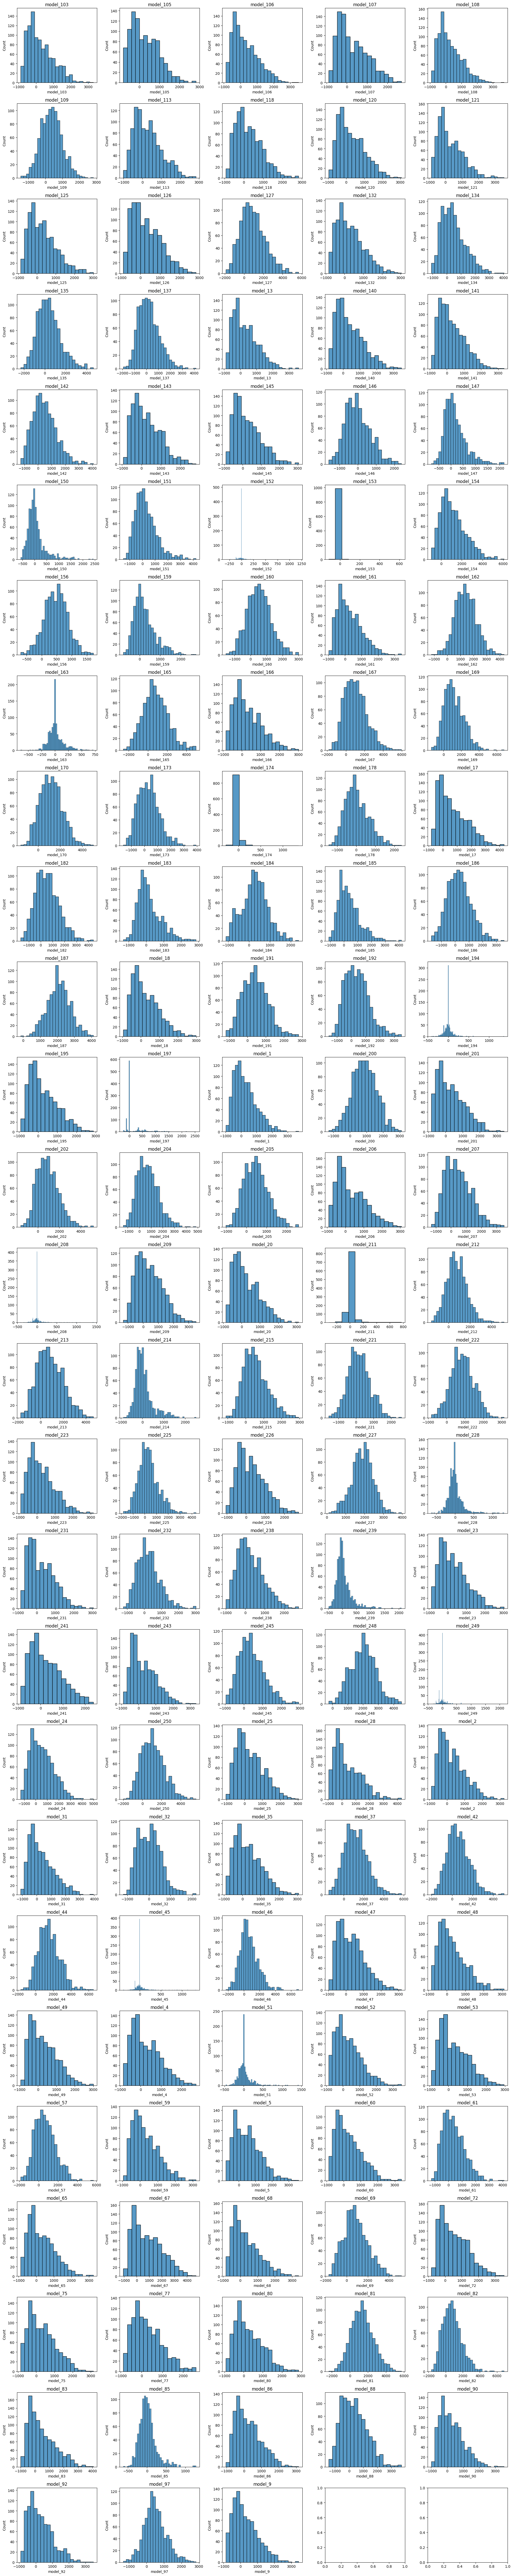

In [37]:
# Create a grid of subplots for every column in df where there are 7 rows and 7 columns that show the distribution of the data

# Create a grid of subplots
fig, axs = plt.subplots(nrows=int(np.ceil(len(df_nan_replaced.columns)/5)), ncols=5, figsize=(20, 100))

# Flatten the axs array
axs = axs.flatten()

# Iterate over the columns in df
for i, col in enumerate(df.columns):
    # Plot the distribution of the column
    sns.histplot(data=df, x=col, ax=axs[i])
    axs[i].set_title(col)

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

In [38]:
numbers = [147,154,156,162,17,187,227]
# 'model_9_2024-06-14.pkl'
models = [f'model_{num}_{max_date_1hr.date()}.pkl' for num in numbers]
orders_rendered = {}
num_episodes = 1
for num, model in tqdm(zip(numbers, models)):

    # model_ppo = PPO('MultiInputPolicy', train_env, verbose=0, ent_coef=m_ppo_ent_coef, learning_rate=m_ppo_lr, gamma=m_ppo_gamma)
    obs_tr, info_tr = train_env.reset(seed=seed)
    model_ppo = PPO.load(f'models_{max_date_1hr.date()}/{model}', train_env)
    # model_ppo.learn(total_timesteps=total_learning_timesteps, callback=ProgressBarCallback(100))   

    rewards = []
    for episode in range(num_episodes):
        obs_test, info_test = env_validation_2.reset(seed=seed)
        # model_ppo = PPO.load(f'gym_mtsim_forked/gym_mtsim/data/model_0.pkl', train_env)
        done_test = False
        while not done_test:
            action, _states = model_ppo.predict(obs_test)
            obs_test, reward_test, terminated_test, truncated_test, info_test = env_validation_2.step(action)
            done_test = terminated_test or truncated_test
            
            total_reward += reward_test
            if done_test:
                break
        orders_rendered[f'{num}'] = env_validation_2.render()['orders']
        try:
            orders_made_in_episode_test = env_validation_2.render()['orders']
            # orders_over_validations_dfs[f'{episode}'] = orders_made_in_episode_test
            order_len = len(orders_made_in_episode_test)
            total_reward, total_profit = my_profit_calculation(orders_made_in_episode_test, 0.001)
            rewards.append(total_profit)
        except Exception as e:
            print(f'There were not any orders produced by the model. Error = {e}')
            rewards.append(0)
            order_len = 0

7it [00:02,  3.38it/s]


In [44]:
for num in numbers:
    print(num)
    print(orders_rendered[f'{num}'].groupby('Type').count()['Volume'])

147
Type
Buy     2
Sell    4
Name: Volume, dtype: int64
154
Type
Buy     2
Sell    3
Name: Volume, dtype: int64
156
Type
Sell    34
Name: Volume, dtype: int64
162
Type
Sell    52
Name: Volume, dtype: int64
17
Type
Buy     13
Sell     9
Name: Volume, dtype: int64
187
Type
Buy      1
Sell    16
Name: Volume, dtype: int64
227
Type
Sell    51
Name: Volume, dtype: int64


In [45]:
print(df_nan_replaced['model_17'].min(),
df_nan_replaced['model_17'].max(),
df_nan_replaced['model_17'].mean(),
len(df_nan_replaced[df_nan_replaced['model_17'] > 0]),
len(df_nan_replaced[df_nan_replaced['model_17'] < 0]))

-815.6398592800277 4318.373548970068 687.2023350689597 675 325
